<a href="https://colab.research.google.com/github/jduell12/DS-Unit-2-Linear-Models/blob/master/C_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

In [362]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Logistic Regression

Do you like burritos? 🌯 You're in luck then, because in this project you'll create a model to predict whether a burrito is `'Great'`.

The dataset for this assignment comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast. 

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function .
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build `model_logr` using a pipeline that includes three transfomers and `LogisticRegression` predictor. Train model on `X_train` and `X_test`.
- **Task 7:** Calculate the training and test accuracy score for your model.
- **Task 8:** Create a horizontal bar chart showing the 10 most influencial features for your  model. 
- **Task 9:** Demonstrate and explain the differences between `model_lr.predict()` and `model_lr.predict_proba()`.

**Note** 

You should limit yourself to the following libraries:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [363]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# I. Wrangle Data

In [364]:
def isChecked(cell):
  cell = cell.lower()
  if cell == 'x' or cell == 'yes':
    return 1
  return 0

def isCal(cell):
  if cell == 'California':
    return 1
  return 0

def isAsada(cell):
  if cell == 'Asada':
    return 1
  return 0

def isCarnitas(cell):
  if cell == 'Carnitas':
    return 1
  return 0

def isSurf(cell):
  if cell == 'Surf & Turf':
    return 1 
  return 0

def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'],
                     index_col='Date').sort_index()
    
    # Drop unrated burritos
    df.dropna(subset=['overall'], inplace=True)
    
    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale
    df['Great'] = (df['overall'] >= 4).astype(int)
    
    # Drop high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Address', 'URL', 'Neighborhood', 'Reviewer'])
    
    # Drop columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall'])

    #replace NaN with 0
    df = df.fillna('0')

    # change columns with object appropiate types
    cols = ['Fries','Cheese','Guac','Pico','NonSD','Unreliable','Beef','Chips','Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans',
       'Lettuce', 'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce',
       'Salsa.1', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham',
       'Chile relleno', 'Nopales', 'Lobster', 'Queso', 'Egg', 'Mushroom',
       'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini']
    for col in cols:
      df[col] = df[col].apply(isChecked)

    float_cols = ['Yelp', 'Google', 'Cost', 'Hunger', 'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
    for col in float_cols:
      df[col] = df[col].apply(float)

    # Change the wrangle function above so that it engineers four new features: 'california', 'asada', 'surf', and 'carnitas'. 
    # Each row should have a 1 or 0 based on the text information in the 'Burrito' column. 
    df['Burrito'] = df['Burrito'].str.lower()

    california = df['Burrito'].str.contains('california')
    asada = df['Burrito'].str.contains('asada')
    surf = df['Burrito'].str.contains('surf')
    carnitas = df['Burrito'].str.contains('carnitas')

    df.loc[california, 'Burrito'] = 'California'
    df.loc[asada, 'Burrito'] = 'Asada'
    df.loc[surf, 'Burrito'] = 'Surf & Turf'
    df.loc[carnitas, 'Burrito'] = 'Carnitas'
    df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

    df['california'] = df['Burrito'].apply(isCal)
    df['asada'] = df['Burrito'].apply(isAsada)
    df['surf'] = df['Burrito'].apply(isSurf)
    df['carnitas'] = df['Burrito'].apply(isCarnitas)

    df = df.drop(columns=['Burrito'])
    
    return df

filepath = DATA_PATH + 'burritos/burritos.csv'

**Task 1:** Use the above `wrangle` function to import the `burritos.csv` file into a DataFrame named `df`.

In [365]:
filepath = DATA_PATH + 'burritos/burritos.csv'
df = wrangle(filepath)

In [366]:
# df.tail()

During your exploratory data analysis, note that there are several columns whose data type is `object` but that seem to be a binary encoding. For example, `df['Beef'].head()` returns:

```
0      x
1      x
2    NaN
3      x
4      x
Name: Beef, dtype: object
```

**Task 2:** Change the `wrangle` function so that these columns are properly encoded as `0` and `1`s. Be sure your code handles upper- and lowercase `X`s, and `NaN`s.

In [367]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

df.select_dtypes(include=['object']).columns





Index([], dtype='object')

If you explore the `'Burrito'` column of `df`, you'll notice that it's a high-cardinality categorical feature. You'll also notice that there's a lot of overlap between the categories. 

**Stretch Goal:** Change the `wrangle` function above so that it engineers four new features: `'california'`, `'asada'`, `'surf'`, and `'carnitas'`. Each row should have a `1` or `0` based on the text information in the `'Burrito'` column. For example, here's how the first 5 rows of the dataset would look.

| **Burrito** | **california** | **asada** | **surf** | **carnitas** |
| :---------- | :------------: | :-------: | :------: | :----------: |
| California  |       1        |     0     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |
|  Carnitas   |       0        |     0     |    0     |      1       |
| Carne asada |       0        |     1     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |

**Note:** Be sure to also drop the `'Burrito'` once you've engineered your new features.

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'Great'`.

In [368]:
target = 'Great'
y = df[target]
X = df.drop(columns=target)

In [369]:
X.head()

,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,california,asada,surf,carnitas
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-16,0.0,0.0,0,8.00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-04-20,0.0,0.0,0,0.00,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-18,3.5,4.2,0,6.49,3.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2016-01-24,0.0,0.0,0,5.25,2.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2016-01-24,0.0,0.0,0,4.85,1.5,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [370]:
y.head()

Date
2011-05-16    0
2015-04-20    1
2016-01-18    0
2016-01-24    0
2016-01-24    0
Name: Great, dtype: int64

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from 2016 through 2017. 
- Your test set should include data from 2018 and later.

In [371]:
cutoff = '2017-12-31'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [372]:
y_train.tail()

Date
2017-09-05    1
2017-09-05    1
2017-12-16    0
2017-12-29    1
2017-12-29    1
Name: Great, dtype: int64

In [373]:
y_test.head()

Date
2018-01-02    0
2018-01-09    0
2018-01-12    0
2018-01-12    1
2018-04-04    1
Name: Great, dtype: int64

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents. 

In [374]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)



Baseline Accuracy Score: 0.5822454308093995


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_logr`, and fit it to your training data. Your pipeline should include:

- a `OneHotEncoder` transformer for categorical features, 
- a `SimpleImputer` transformer to deal with missing values, 
- a [`StandarScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transfomer (which often improves performance in a logistic regression model), and 
- a `LogisticRegression` predictor.

In [375]:
model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

model_logr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

In [376]:
training_acc = model_logr.score(X_train, y_train)
test_acc = model_logr.score(X_test, y_test)

print('Training MAE:', training_acc)
print('Test MAE:', test_acc)

Training MAE: 0.8955613577023499
Test MAE: 0.7368421052631579


# V. Communicate Results

**Task 8:** Create a horizontal barchart that plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

**Note:** Since you created your model using a `Pipeline`, you'll need to use the [`named_steps`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) attribute to access the coefficients in your `LogisticRegression` predictor. Be sure to look at the shape of the coefficients array before you combine it with the feature names.

In [377]:
model_logr.named_steps

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'onehotencoder': OneHotEncoder(cols=[], drop_invariant=False, handle_missing='value',
               handle_unknown='value', return_df=True, use_cat_names=True,
               verbose=0),
 'simpleimputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               missing_values=nan, strategy='mean', verbose=0),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [378]:
coeff = model_logr['logisticregression'].coef_[0]
features = model_logr['onehotencoder'].get_feature_names()

print(len(coeff))
print(len(features))


60
60


In [379]:
feature_imp = pd.Series(coeff, index=features).sort_values(key=abs)

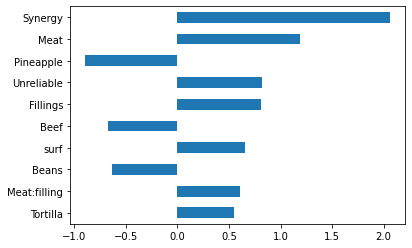

In [380]:
# Create your horizontal barchart here.
feature_imp.tail(10).plot(kind='barh')

There is more than one way to generate predictions with `model_lr`. For instance, you can use [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression) or [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.predict_proba).

**Task 9:** Generate predictions for `X_test` using both `predict` and `predict_proba`. Then below, write a summary of the differences in the output for these two methods. You should answer the following questions:

- What data type do `predict` and `predict_proba` output?
- What are the shapes of their different output?
- What numerical values are in the output?
- What do those numerical values represent?

In [387]:
# Write code here to explore the differences between `predict` and `predict_proba`.
predict = model_logr.predict(X_test)
type(predict[0])

numpy.int64

In [403]:
predict_proba = model_logr.predict_proba(X_test)
np.sort(predict_proba).max()


0.9999964289879676

**Give your written answer here:**
* What data type do predict and predict_proba output?

Predict is an int while predict_proba is a float

* What are the shapes of their different output?

Both have a length of 38 in their array.

* What numerical values are in the output?

Predict has either 1 or 0 and predict_proba has a range from almost 0 to almost 1.

* What do those numerical values represent?
Predict returns either a 1 or 0 which represents if that burrito will be Great or not. Predict_porba returns a float which represents the probability estimates for each column. 